In [6]:
from dataclasses import dataclass, field
from functools import reduce
from itertools import product

import igraph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pynauty
import scipy.sparse as sp
from scipy.linalg import ishermitian
from sympy.combinatorics import Permutation, PermutationGroup

from utils import setup_igraph

np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None)

# Spin-1 XY model

In [3]:
s_up = np.sqrt(2) * sp.csr_array(np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]))
s_down = np.sqrt(2) * sp.csr_array(np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0]]))
s_z = sp.csr_array(np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]]))
local_hopping = sp.kron(s_up, s_down) + sp.kron(s_down, s_up)


@dataclass(slots=True)
class Spin1XYModel:
    n: int
    coup_j: float
    coup_h: float
    periodic: bool = False
    _kinetic_term: sp.sparray = field(init=False, repr=False)
    _potential_term: sp.sparray = field(init=False, repr=False)
    _hamiltonian: sp.sparray = field(init=False, repr=False)

    def __post_init__(self):
        self._kinetic_term = sp.csr_array((3 ** self.n, 3 ** self.n), dtype=float)
        self._potential_term = sp.csr_array((3 ** self.n, 3 ** self.n), dtype=float)
        self._hamiltonian = sp.csr_array((3 ** self.n, 3 ** self.n), dtype=float)
        for site in range(self.n - 1):
            self._kinetic_term += 0.5 * reduce(sp.kron, [sp.eye(3 ** site), local_hopping, sp.eye(3 ** (self.n - 2 - site))])
        for site in range(self.n):
            self._potential_term += reduce(sp.kron, [sp.eye(3 ** site), s_z, sp.eye(3 ** (self.n - 1 - site))])
        if self.periodic:
            self._kinetic_term += 0.5 * reduce(sp.kron, [s_down, sp.eye(3 ** (self.n - 2)), s_up])
            self._kinetic_term += 0.5 * reduce(sp.kron, [s_up, sp.eye(3 ** (self.n - 2)), s_down])
        self._hamiltonian += self.coup_j * self._kinetic_term + self.coup_h * self._potential_term

    @property
    def kinetic_term(self):
        return self._kinetic_term
    
    @property
    def potential_term(self):
        return self._potential_term
    
    @property
    def hamiltonian(self):
        return self._hamiltonian

In [75]:
{i: j for i, j in enumerate(product([1, 0, -1], repeat=2))}

{0: (1, 1),
 1: (1, 0),
 2: (1, -1),
 3: (0, 1),
 4: (0, 0),
 5: (0, -1),
 6: (-1, 1),
 7: (-1, 0),
 8: (-1, -1)}

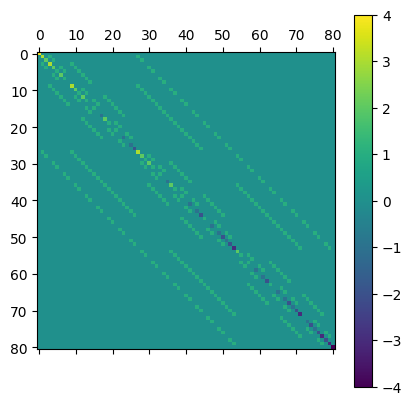

In [77]:
coup_j, coup_h = (1, 1)
model = Spin1XYModel(4, coup_j, coup_h, periodic=True)
mat = model.hamiltonian.toarray()
assert ishermitian(mat)
evals, evecs = np.linalg.eigh(mat)

plt.matshow(mat)
plt.colorbar()

In [117]:
evecs_df = pd.DataFrame.from_dict(
    {
        "eval": evals,
        "kin": [(evec.T @ model.kinetic_term @ evec).item() for evec in evecs.T],
        "pot": [(evec.T @ model.potential_term @ evec).item() for evec in evecs.T],
        "kin^2": [(evec.T @ model.kinetic_term @ model.kinetic_term @ evec).item() for evec in evecs.T],
        "pot^2": [(evec.T @ model.potential_term @ model.potential_term @ evec).item() for evec in evecs.T],
    }
)
evecs_df[evecs_df["kin"].abs() < 1e-12]

,eval,kin,pot,kin^2,pot^2
4,-4.0,0.000000e+00,-4.0,0.000000e+00,16.0
10,-3.0,-3.152918e-30,-3.0,6.710375e-30,9.0
11,-3.0,7.206118e-32,-3.0,7.580092e-31,9.0
25,-1.0,-5.936871e-18,-1.0,1.687336e-29,1.0
27,-1.0,-3.182652e-17,-1.0,3.044554e-30,1.0
28,-1.0,8.322995e-13,-1.0,1.664618e-12,1.0
49,1.0,4.683025e-18,1.0,1.919604e-29,1.0
51,1.0,-2.822497e-18,1.0,2.025800e-29,1.0
52,1.0,-2.352908e-17,1.0,1.649829e-29,1.0
53,1.0,3.001317e-29,1.0,7.472689e-29,1.0


(array([17, 23, 41, 43, 47, 49, 61, 65, 67, 69]),)

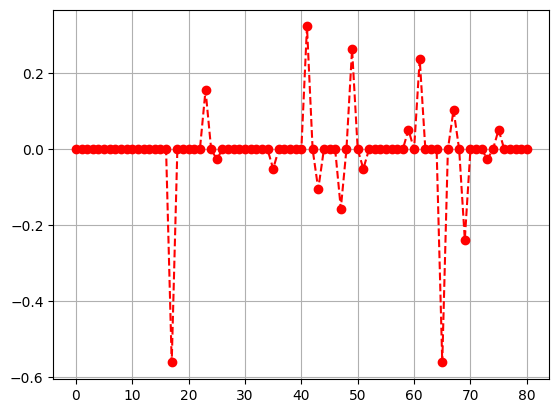

In [118]:
i = 25
plt.plot(evecs[:, i].T, linestyle="--", marker="o", color="red")
plt.grid()
np.where(np.abs(evecs[:, i]) > 0.1)

In [78]:
g = nx.from_scipy_sparse_array(model.kinetic_term)
ig = igraph.Graph.from_networkx(g)

ntg = pynauty.Graph(
    ig.vcount(),
    directed=True,
    adjacency_dict=nx.to_dict_of_lists(g),
)
aut_gp = pynauty.autgrp(ntg)[0]

perm_gp = PermutationGroup([Permutation(p) for p in aut_gp])

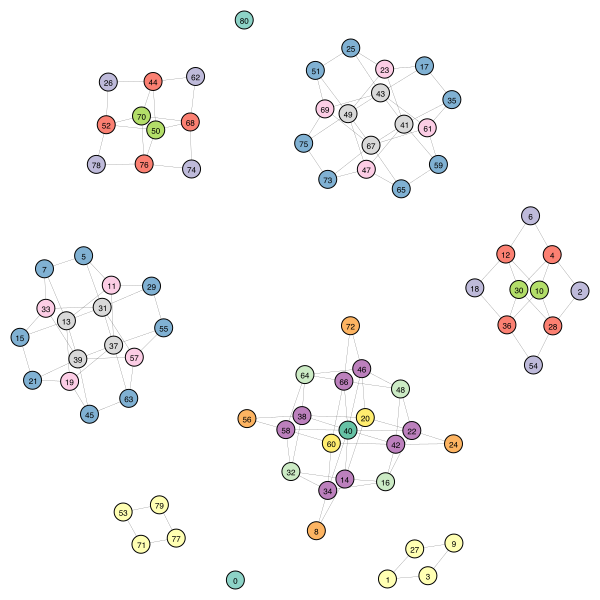

In [80]:
g = nx.from_scipy_sparse_array(model.kinetic_term)

highlight = [
    # np.where(np.abs(evecs[:, 231]) > 1e-6)[0],
]
# highlight = list(aut.degree_partition.values())
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))

# highlight_color = list(mcolors.TABLEAU_COLORS.values())
# highlight_color = list(mcolors.CSS4_COLORS.values())
cmap = plt.get_cmap('Set3')
highlight_color = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
highlight_color *= 2000
# highlight_color = [
#     "dimgray",
#     "whitesmoke",
#     "deepskyblue",
#     "yellowgreen",
#     "aqua",
#     "pink",
#     "tomato",
#     "royalblue",
#     "blueviolet",
#     "cornflowerblue",
#     "limegreen",
# ]

ig = setup_igraph(g, highlight, highlight_color)

degree = np.array(list(dict(g.degree).values()))
# (bipartite, types) = ig.is_bipartite(return_types=True)
# nodes = [int(n) for n in list(sub_sub_ig.vs["label"])]
# outer_boundary = list(nx.node_boundary(g, nodes))
# sub_ig = ig.induced_subgraph(np.append(nodes, outer_boundary))

# sub_ig = ig.induced_subgraph(np.where(degree == 8)[0])
# fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
igraph.plot(
    ig,
    # layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=18,
    vertex_label_size=8,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_color="darkgray",
    # target="qdm_subgraph_4x4.svg"
)

In [81]:
sub_components = ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(ig.subgraph(c).to_networkx())
    print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat), nx.is_bipartite(ig.subgraph(c).to_networkx()))

0 1 1 True
1 4 2 True
2 10 4 True
3 16 6 True
4 19 9 True
5 16 6 True
6 10 4 True
7 4 2 True
8 1 1 True
